In [1]:
# Import all libraries and dependencies
import pandas as pd
import os
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
import matplotlib.figure as figure
from prophet import Prophet

In [2]:
# Set default options for pandas and other libraries
pd.set_option('display.max_colwidth', None)

In [3]:
# Set all global variables
start_year = 2010
end_year = 2019

In [4]:
# Import CSV files
# economy_df = pd.read_csv("../Resources/Economy_Data.csv", delimiter=';')
# education_environment_df = pd.read_csv("../Resources/EducationAndEnviron_Data.csv", delimiter=';')
# health_poverty_df = pd.read_csv("../Resources/HealthAndpoverty_Data.csv", delimiter=';')
# private_sector_df = pd.read_csv("../Resources/privatesector_Data.csv", delimiter=';')
# public_sector_df = pd.read_csv("../Resources/PublicSector_Indicators.csv", delimiter=';')

# Import Excel files
economy_raw_df = pd.read_excel("../Resources/BRICS Economic Data.xlsx", sheet_name="Data")
education_environment_raw_df = pd.read_excel("../Resources/BRICS Education and Environment Data.xlsx", sheet_name="Data")
health_poverty_raw_df = pd.read_excel("../Resources/BRICS Health and Poverty Data.xlsx", sheet_name="Data")
private_sector_raw_df = pd.read_excel("../Resources/BRICS Private Sector Data.xlsx", sheet_name="Data")
public_sector_raw_df = pd.read_excel("../Resources/BRICS Public Sector and Society Data.xlsx", sheet_name="Data")

In [5]:
# Study the dataframes and understand the data

df_shapes = {
    'dataframe': ['economy', 'education_environment', 'health_poverty', 'private_sector', 'public_sector'],
    'shape': [economy_raw_df.shape, education_environment_raw_df.shape, health_poverty_raw_df.shape, private_sector_raw_df.shape, public_sector_raw_df.shape],
    'total_nans': [economy_raw_df.isna().sum().sum(), education_environment_raw_df.isna().sum().sum(), health_poverty_raw_df.isna().sum().sum(), private_sector_raw_df.isna().sum().sum(), public_sector_raw_df.isna().sum().sum()]
}

df_shapes = pd.DataFrame(df_shapes)

df_shapes

,dataframe,shape,total_nans
0,economy,"(1730, 55)",26550
1,education_environment,"(1430, 55)",41592
2,health_poverty,"(1390, 55)",38949
3,private_sector,"(845, 55)",25124
4,public_sector,"(1600, 55)",54804


In [6]:
# Function to standardize column names
def year_col_name(cols):
    new_cols = []
    for col in cols:
        if '[YR' in col: # if it's a year col, append only the number
            new_cols.append(col.split(' ')[0])
        elif ' ' in col: # this must be the second check due to ambiguity
            new_cols.append(col.replace(' ', '_'))
        else: # if the column doesn't meet any criteria, append it as it is
            new_cols.append(col)
    return new_cols

In [7]:
# Modify the column names (Here we are targeting only the year column). We might need to mofdify more columns in the future
economy_raw_df.columns = year_col_name(economy_raw_df.columns)
education_environment_raw_df.columns = year_col_name(education_environment_raw_df.columns)
health_poverty_raw_df.columns = year_col_name(health_poverty_raw_df.columns)
private_sector_raw_df.columns = year_col_name(private_sector_raw_df.columns)
public_sector_raw_df.columns = year_col_name(public_sector_raw_df.columns)

In [8]:
# Using melt function here to unpivot the dataframes
economy_melted_df = economy_raw_df.melt(id_vars=['Country_Name', 'Country_Code', 'Series_Name', 'Series_Code'], var_name='Year', value_name='Value')
education_environment_melted_df = education_environment_raw_df.melt(id_vars=['Country_Name', 'Country_Code', 'Series_Name', 'Series_Code'], var_name='Year', value_name='Value')
health_poverty_melted_df = health_poverty_raw_df.melt(id_vars=['Country_Name', 'Country_Code', 'Series_Name', 'Series_Code'], var_name='Year', value_name='Value')
private_sector_melted_df = private_sector_raw_df.melt(id_vars=['Country_Name', 'Country_Code', 'Series_Name', 'Series_Code'], var_name='Year', value_name='Value')
public_sector_melted_df = public_sector_raw_df.melt(id_vars=['Country_Name', 'Country_Code', 'Series_Name', 'Series_Code'], var_name='Year', value_name='Value')

# Preview the dataframes
display(economy_melted_df.head(1))
display(education_environment_melted_df.head(1))
display(health_poverty_melted_df.head(1))
display(private_sector_melted_df.head(1))
display(public_sector_melted_df.head(1))

,Country_Name,Country_Code,Series_Name,Series_Code,Year,Value
0,Brazil,BRA,Adjusted net national income (annual % growth),NY.ADJ.NNTY.KD.ZG,1970,NaN


,Country_Name,Country_Code,Series_Name,Series_Code,Year,Value
0,Brazil,BRA,Access to clean fuels and technologies for cooking (% of population),EG.CFT.ACCS.ZS,1970,NaN


,Country_Name,Country_Code,Series_Name,Series_Code,Year,Value
0,Brazil,BRA,"Adolescent fertility rate (births per 1,000 women ages 15-19)",SP.ADO.TFRT,1970,77.1184


,Country_Name,Country_Code,Series_Name,Series_Code,Year,Value
0,Brazil,BRA,Agricultural raw materials exports (% of merchandise exports),TX.VAL.AGRI.ZS.UN,1970,11.895098


,Country_Name,Country_Code,Series_Name,Series_Code,Year,Value
0,Brazil,BRA,Adequacy of social insurance programs (% of total welfare of beneficiary households),per_si_allsi.adq_pop_tot,1970,NaN


In [9]:
display(economy_melted_df.isna().sum())
display(education_environment_melted_df.isna().sum())
display(health_poverty_melted_df.isna().sum())
display(private_sector_melted_df.isna().sum())
display(public_sector_melted_df.isna().sum())

Country_Name      153
Country_Code      255
Series_Name       255
Series_Code       255
Year                0
Value           26532
dtype: int64

Country_Name      153
Country_Code      255
Series_Name       255
Series_Code       255
Year                0
Value           41574
dtype: int64

Country_Name      153
Country_Code      255
Series_Name       255
Series_Code       255
Year                0
Value           38931
dtype: int64

Country_Name      153
Country_Code      255
Series_Name       255
Series_Code       255
Year                0
Value           25106
dtype: int64

Country_Name      153
Country_Code      255
Series_Name       255
Series_Code       255
Year                0
Value           54786
dtype: int64

In [10]:
# Function to return dataframe based on start_year and end_year
def fn_df_year_filter(df, start_year, end_year):
    return df[(df['Year'] >= start_year) & (df['Year'] <= end_year)].reset_index(drop=True)

def fn_df_set_data_types(df):
    return df.astype({'Country_Name': 'string',
                      'Country_Code': 'string',
                      'Series_Name': 'string',
                      'Series_Code': 'string',
                      'Year': 'int'})

In [11]:
# This section is to modify the data and finalize the dataframes to proceed with our analysis

# Drop all NaN values
economy_modified_df = economy_melted_df.dropna()
education_environment_modified_df = education_environment_melted_df.dropna()
health_poverty_modified_df = health_poverty_melted_df.dropna()
private_sector_modified_df = private_sector_melted_df.dropna()
public_sector_modified_df = public_sector_melted_df.dropna()

# Modify data types for all dataframes
economy_modified_df = fn_df_set_data_types(economy_modified_df)
education_environment_modified_df = fn_df_set_data_types(education_environment_modified_df)
health_poverty_modified_df = fn_df_set_data_types(health_poverty_modified_df)
private_sector_modified_df = fn_df_set_data_types(private_sector_modified_df)
public_sector_modified_df = fn_df_set_data_types(public_sector_modified_df)

In [12]:
# Restrict dataframes last 10 years of data
economy_final_df = fn_df_year_filter(economy_modified_df, start_year, end_year)
education_environment_final_df = fn_df_year_filter(education_environment_modified_df, start_year, end_year)
health_poverty_final_df = fn_df_year_filter(health_poverty_modified_df, start_year, end_year)
private_sector_final_df = fn_df_year_filter(private_sector_modified_df, start_year, end_year)
public_sector_final_df = fn_df_year_filter(public_sector_modified_df, start_year, end_year)

display(economy_final_df.info())
display(education_environment_final_df.info())
display(health_poverty_final_df.info())
display(private_sector_final_df.info())
display(public_sector_final_df.info())

display(economy_final_df.head(1))
display(education_environment_final_df.head(1))
display(health_poverty_final_df.head(1))
display(private_sector_final_df.head(1))
display(public_sector_final_df.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14912 entries, 0 to 14911
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country_Name  14912 non-null  string 
 1   Country_Code  14912 non-null  string 
 2   Series_Name   14912 non-null  string 
 3   Series_Code   14912 non-null  string 
 4   Year          14912 non-null  int64  
 5   Value         14912 non-null  float64
dtypes: float64(1), int64(1), string(4)
memory usage: 699.1 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7299 entries, 0 to 7298
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country_Name  7299 non-null   string 
 1   Country_Code  7299 non-null   string 
 2   Series_Name   7299 non-null   string 
 3   Series_Code   7299 non-null   string 
 4   Year          7299 non-null   int64  
 5   Value         7299 non-null   float64
dtypes: float64(1), int64(1), string(4)
memory usage: 342.3 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8805 entries, 0 to 8804
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country_Name  8805 non-null   string 
 1   Country_Code  8805 non-null   string 
 2   Series_Name   8805 non-null   string 
 3   Series_Code   8805 non-null   string 
 4   Year          8805 non-null   int64  
 5   Value         8805 non-null   float64
dtypes: float64(1), int64(1), string(4)
memory usage: 412.9 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country_Name  6234 non-null   string 
 1   Country_Code  6234 non-null   string 
 2   Series_Name   6234 non-null   string 
 3   Series_Code   6234 non-null   string 
 4   Year          6234 non-null   int64  
 5   Value         6234 non-null   float64
dtypes: float64(1), int64(1), string(4)
memory usage: 292.3 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9625 entries, 0 to 9624
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country_Name  9625 non-null   string 
 1   Country_Code  9625 non-null   string 
 2   Series_Name   9625 non-null   string 
 3   Series_Code   9625 non-null   string 
 4   Year          9625 non-null   int64  
 5   Value         9625 non-null   float64
dtypes: float64(1), int64(1), string(4)
memory usage: 451.3 KB


None

,Country_Name,Country_Code,Series_Name,Series_Code,Year,Value
0,Brazil,BRA,Adjusted net national income (annual % growth),NY.ADJ.NNTY.KD.ZG,2010,5.155433


,Country_Name,Country_Code,Series_Name,Series_Code,Year,Value
0,Brazil,BRA,Access to clean fuels and technologies for cooking (% of population),EG.CFT.ACCS.ZS,2010,94.0


,Country_Name,Country_Code,Series_Name,Series_Code,Year,Value
0,Brazil,BRA,"Adolescent fertility rate (births per 1,000 women ages 15-19)",SP.ADO.TFRT,2010,66.8926


,Country_Name,Country_Code,Series_Name,Series_Code,Year,Value
0,Brazil,BRA,Agricultural raw materials exports (% of merchandise exports),TX.VAL.AGRI.ZS.UN,2010,3.88294


,Country_Name,Country_Code,Series_Name,Series_Code,Year,Value
0,Brazil,BRA,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,2010,1302.474648


In [13]:
# Concat all dataframes and collect global data

merged_all_df = pd.concat([economy_final_df, education_environment_final_df, health_poverty_final_df, private_sector_final_df, public_sector_final_df])

# Series dictionary to map Series_Code to Series_Name
dict_series = dict(merged_all_df[['Series_Code', 'Series_Name']].drop_duplicates().reset_index(drop=True).values)

# Countries dictionary to map Country_Code to Country_Name
dict_countries = dict(merged_all_df[['Country_Code', 'Country_Name']].drop_duplicates().reset_index(drop=True).values)

In [14]:
display(health_poverty_final_df['Series_Name'].unique())

<StringArray>
[                                                    'Adolescent fertility rate (births per 1,000 women ages 15-19)',
                                                'Adults (ages 15+) and children (ages 0-14) newly infected with HIV',
                                                                'Age dependency ratio (% of working-age population)',
                                                           'Age dependency ratio, old (% of working-age population)',
                                                         'Age dependency ratio, young (% of working-age population)',
                                                     'Antiretroviral therapy coverage (% of people living with HIV)',
                                                                              'Birth rate, crude (per 1,000 people)',
                                                              'Births attended by skilled health staff (% of total)',
             'Cause of death, by communica

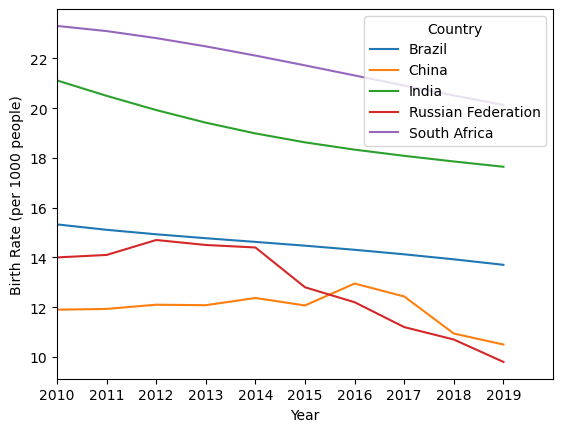

In [15]:
# Plotting Birth Rate (per 1000 people)
birth_rate = health_poverty_final_df.loc[health_poverty_final_df['Series_Code'] == 'SP.DYN.CBRT.IN'].reset_index(drop=True)

for country in birth_rate['Country_Code'].unique():
    country_data = birth_rate.loc[birth_rate['Country_Code'] == country]
    plt.plot(country_data['Year'], country_data['Value'], label=dict_countries[country])

plt.legend(title="Country", loc="upper right")
plt.xticks(np.arange(start_year, end_year + 1, 1))
plt.xlim(start_year, end_year + 1)
plt.xlabel("Year")
plt.ylabel("Birth Rate (per 1000 people)")

plt.show()

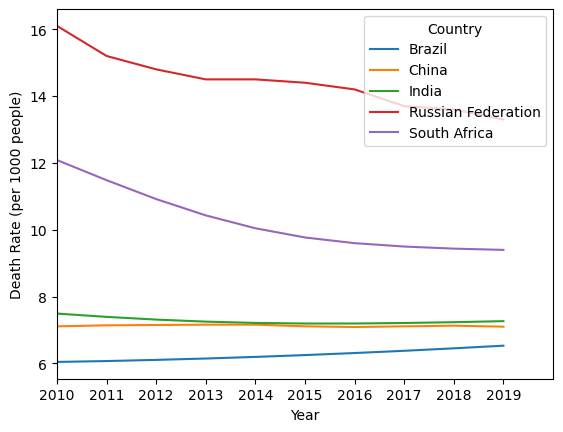

In [16]:
# Plotting Death Rate (per 1000 people)
death_rate = health_poverty_final_df.loc[health_poverty_final_df['Series_Code'] == 'SP.DYN.CDRT.IN'].reset_index(drop=True)

for country in death_rate['Country_Code'].unique():
    country_data = death_rate.loc[death_rate['Country_Code'] == country]
    plt.plot(country_data['Year'], country_data['Value'], label=dict_countries[country])

plt.legend(title="Country", loc="upper right")
plt.xticks(np.arange(start_year, end_year + 1, 1))
plt.xlim(start_year, end_year + 1)
plt.xlabel("Year")
plt.ylabel("Death Rate (per 1000 people)")

plt.show()

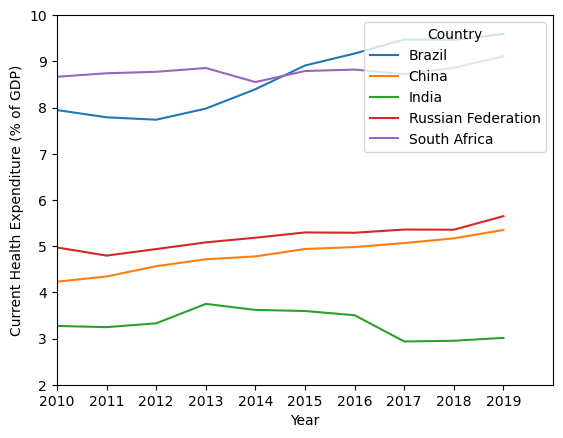

In [17]:
# Plotting Current Health Expenditure (% of GDP)
current_health_expenditure = health_poverty_final_df.loc[health_poverty_final_df['Series_Code'] == 'SH.XPD.CHEX.GD.ZS'].reset_index(drop=True)

min_floor_current_health_expenditure = np.floor(current_health_expenditure['Value'].min())
max_ceil_current_health_expenditure = np.ceil(current_health_expenditure['Value'].max())

for country in current_health_expenditure['Country_Code'].unique():
    country_data = current_health_expenditure.loc[current_health_expenditure['Country_Code'] == country]
    plt.plot(country_data['Year'], country_data['Value'], label=dict_countries[country])

plt.legend(title="Country", loc="upper right")
plt.xticks(np.arange(start_year, end_year + 1, 1))
plt.xlim(start_year, end_year + 1)
plt.ylim(min_floor_current_health_expenditure, max_ceil_current_health_expenditure)
plt.xlabel("Year")
plt.ylabel("Current Health Expenditure (% of GDP)")

plt.show()

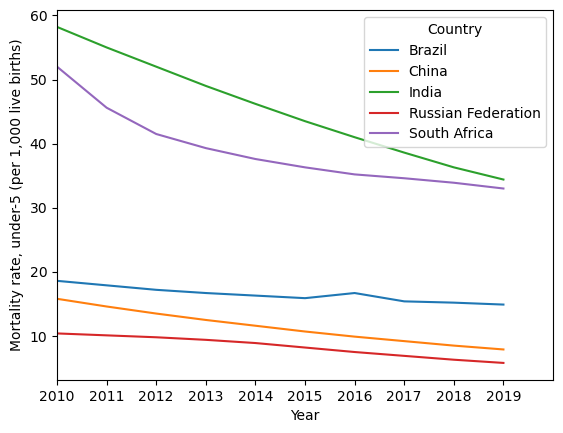

In [18]:
# Plotting Mortality rate, under-5 (per 1,000 live births)
mortality_rate = health_poverty_final_df.loc[health_poverty_final_df['Series_Code'] == 'SH.DYN.MORT'].reset_index(drop=True)

for country in mortality_rate['Country_Code'].unique():
    country_data = mortality_rate.loc[mortality_rate['Country_Code'] == country]
    plt.plot(country_data['Year'], country_data['Value'], label=dict_countries[country])

plt.legend(title="Country", loc="upper right")
plt.xticks(np.arange(start_year, end_year + 1, 1))
plt.xlim(start_year, end_year + 1)
plt.xlabel("Year")
plt.ylabel("Mortality rate, under-5 (per 1,000 live births)")

plt.show()

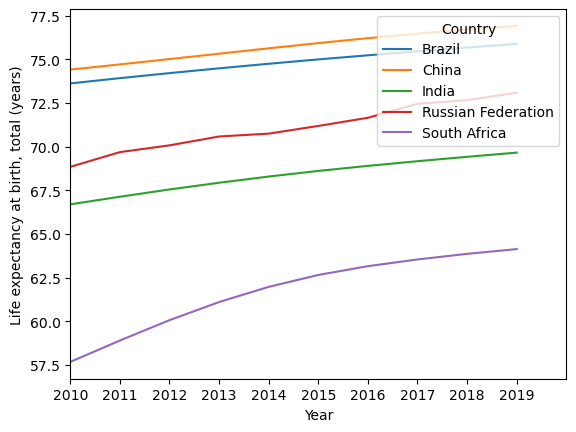

In [19]:
# Plotting Life expectancy at birth, total (years)
life_expectancy = health_poverty_final_df.loc[health_poverty_final_df['Series_Code'] == 'SP.DYN.LE00.IN'].reset_index(drop=True)

for country in life_expectancy['Country_Code'].unique():
    country_data = life_expectancy.loc[life_expectancy['Country_Code'] == country]
    plt.plot(country_data['Year'], country_data['Value'], label=dict_countries[country])

plt.legend(title="Country", loc="upper right")
plt.xticks(np.arange(start_year, end_year + 1, 1))
plt.xlim(start_year, end_year + 1)
plt.xlabel("Year")
plt.ylabel("Life expectancy at birth, total (years)")

plt.show()

In [20]:
# Collecting Health correlation data

health_correlation = \
    health_poverty_final_df.loc[(health_poverty_final_df['Series_Code'] == 'SH.XPD.CHEX.GD.ZS')\
                                | (health_poverty_final_df['Series_Code'] == 'SH.DYN.MORT')\
                                | (health_poverty_final_df['Series_Code'] == 'SP.DYN.LE00.IN')]\
                            .reset_index(drop=True)

health_correlation.head()

,Country_Name,Country_Code,Series_Name,Series_Code,Year,Value
0,Brazil,BRA,Current health expenditure (% of GDP),SH.XPD.CHEX.GD.ZS,2010,7.945160
1,Brazil,BRA,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,2010,73.619000
2,Brazil,BRA,"Mortality rate, under-5 (per 1,000 live births)",SH.DYN.MORT,2010,18.600000
3,China,CHN,Current health expenditure (% of GDP),SH.XPD.CHEX.GD.ZS,2010,4.230683
4,China,CHN,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,2010,74.409000


In [21]:
health_correlation = health_correlation.pivot(index=['Country_Code', 'Year'], columns="Series_Code", values="Value")

health_correlation['SH.DYN.MORT'] = health_correlation['SH.DYN.MORT'].apply(lambda x: x / 1000 * 100)

health_correlation = health_correlation.reset_index()

health_correlation.head()

Series_Code,Country_Code,Year,SH.DYN.MORT,SH.XPD.CHEX.GD.ZS,SP.DYN.LE00.IN
0,BRA,2010,1.86,7.945160,73.619
1,BRA,2011,1.79,7.788195,73.921
2,BRA,2012,1.72,7.736377,74.209
3,BRA,2013,1.67,7.976600,74.483
4,BRA,2014,1.63,8.396446,74.745


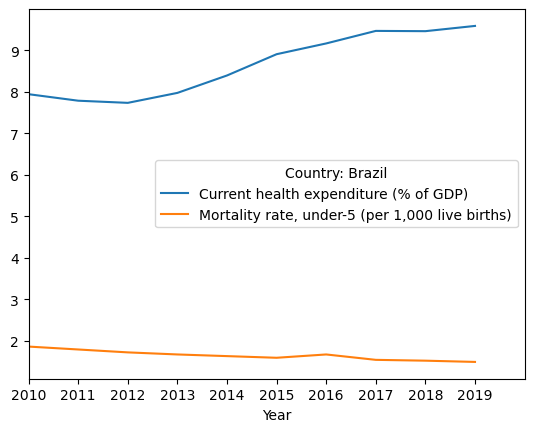

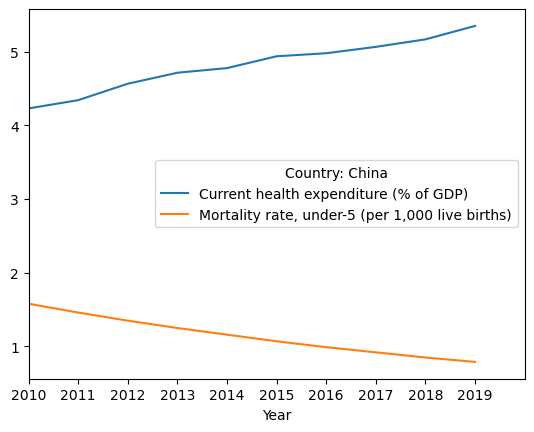

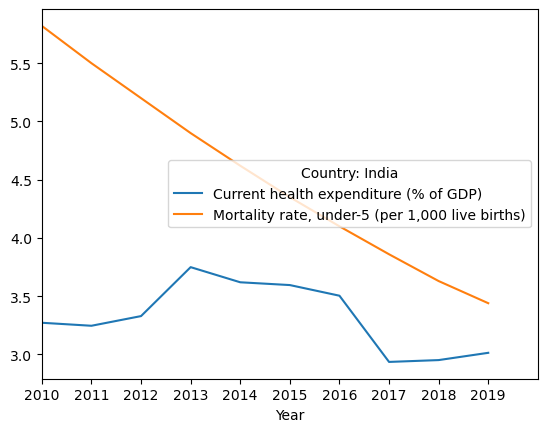

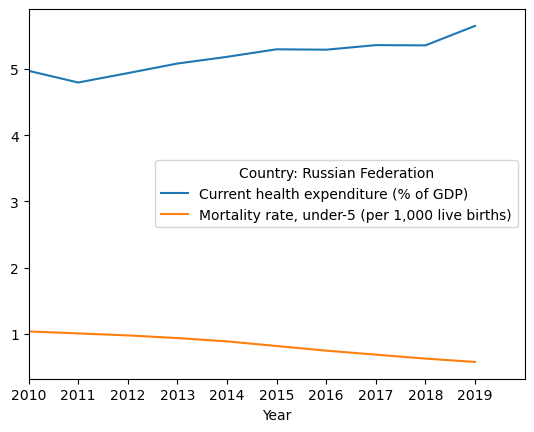

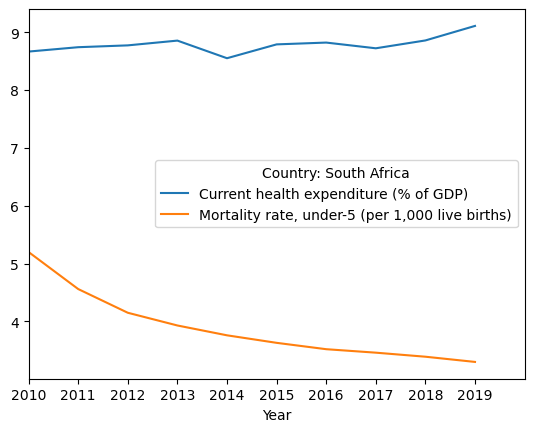

In [22]:
# Relation between Current Health Expenditure and Mortality rate
for country in health_correlation['Country_Code'].unique():
    country_data = health_correlation.loc[health_correlation['Country_Code'] == country]
    plt.plot(country_data['Year'], country_data['SH.XPD.CHEX.GD.ZS'], label=f'{dict_series['SH.XPD.CHEX.GD.ZS']}')
    plt.plot(country_data['Year'], country_data['SH.DYN.MORT'], label=f'{dict_series['SH.DYN.MORT']}')
    
    plt.xticks(np.arange(start_year, end_year + 1, 1))
    plt.xlim(start_year, end_year + 1)
    plt.xlabel('Year')

    plt.legend(title=f'Country: {dict_countries[country]}', loc="center right")
    
    plt.show()

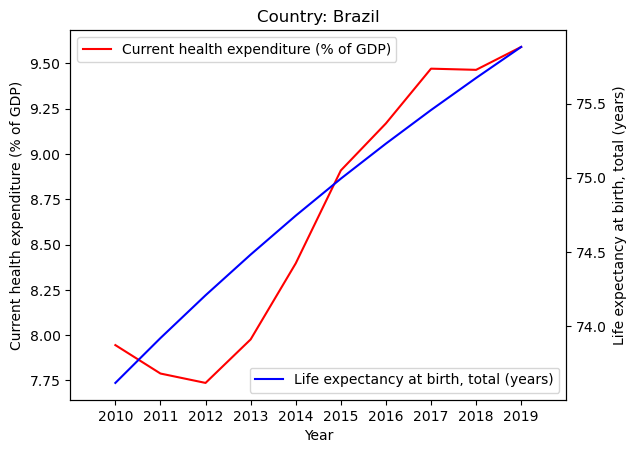

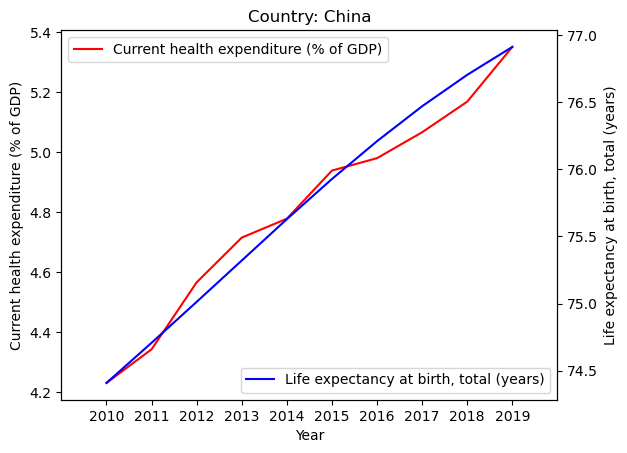

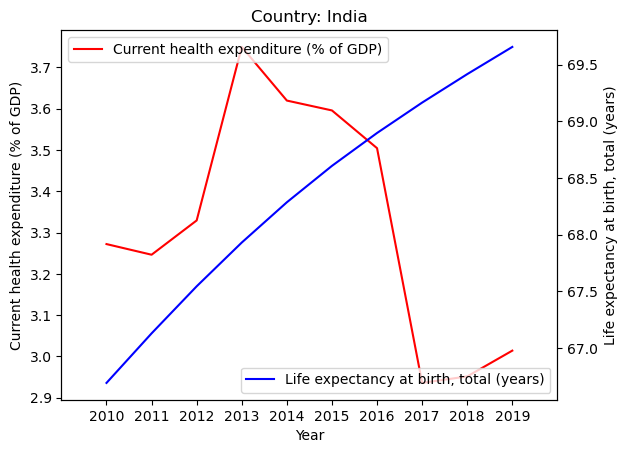

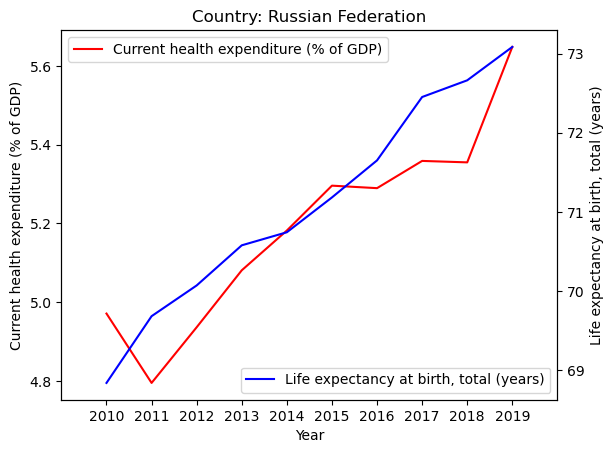

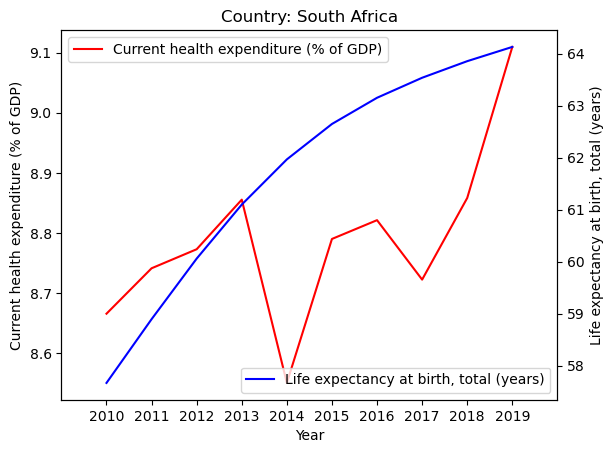

In [23]:
#Relation between Current Health Expenditure and Life Expectancy
for country in health_correlation['Country_Code'].unique():
    country_data = health_correlation.loc[health_correlation['Country_Code'] == country]
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(country_data['Year'], country_data['SH.XPD.CHEX.GD.ZS'], label=f'{dict_series['SH.XPD.CHEX.GD.ZS']}', color='r')
    ax2.plot(country_data['Year'], country_data['SP.DYN.LE00.IN'], label=f'{dict_series['SP.DYN.LE00.IN']}', color='b')
    
    ax1.set_xlabel('Year')
    ax1.set_ylabel(f'{dict_series['SH.XPD.CHEX.GD.ZS']}')
    ax2.set_ylabel(f'{dict_series['SP.DYN.LE00.IN']}')
    
    plt.xticks(np.arange(start_year, end_year + 1, 1))
    plt.xlim(start_year - 1, end_year + 1)

    ax1.legend(loc='upper left')
    ax2.legend(loc='lower right')
    
    plt.title(f'Country: {dict_countries[country]}')
    
    plt.show()